In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

# I see functions, function definitions everywhere

In [ ]:
# Gumbel distribution (https://en.wikipedia.org/wiki/Gumbel_distribution)
def gumbel_pdf(x,mu,sigma):
    beta = sigma*(np.sqrt(6)/np.pi)
    z=(x-mu)/beta
    return (1/beta)*np.exp(-(z+np.exp(-1*z)))

# a simple function to downsample an array by factor N
def downsample(x, N):
        return np.append(x,np.zeros(len(x)%N)*np.nan).reshape(-1,N).mean(axis=1)

#@nb.jit(nopython=True, cache=False)  # cache=False only for performance comparison
def numba_ix(arr, rows, cols):
    """
    Numba compatible implementation of arr[np.ix_(rows, cols)] for 2D arrays.
    from https://github.com/numba/numba/issues/5894#issuecomment-974701551
    :param arr: 2D array to be indexed
    :param rows: Row indices
    :param cols: Column indices
    :return: 2D array with the given rows and columns of the input array
    """
    one_d_index = np.zeros(len(rows) * len(cols), dtype=np.int32)
    for i, r in enumerate(rows):
        start = i * len(cols)
        one_d_index[start: start + len(cols)] = cols + arr.shape[1] * r

    arr_1d = arr.reshape((arr.shape[0] * arr.shape[1], 1))
    slice_1d = np.take(arr_1d, one_d_index)
    return slice_1d.reshape((len(rows), len(cols)))


def nnls(A, b, maxiter=None, tol=None):
    """
    based on scipy implementation. Which in turn is based on
    the algorithm given in  :doi:`10.1002/cem.889`
    """
    m, n = A.shape

    AtA = np.transpose(A) @ A
    Atb = b @ A  # Result is 1D - let NumPy figure it out

    if not maxiter:
        maxiter = 3*n
    if tol is None:
        tol = 10 * max(m, n) * np.spacing(1.)

    # Initialize vars
    x = np.zeros(n, dtype=np.float64)
    s = np.zeros(n, dtype=np.float64)
    # Inactive constraint switches
    P = np.zeros(n, dtype=bool)
    Pidx = np.arange(0,len(P),1,dtype=int)

    # Projected residual
    w = Atb.copy().astype(np.float64)  # x=0. Skip (-AtA @ x) term

    # Overall iteration counter
    # Outer loop is not counted, inner iter is counted across outer spins
    iter = 0

    while (not P.all()) and (w[~P] > tol).any():  # B
        # Get the "most" active coeff index and move to inactive set
        k = np.argmax(w * (~P))  # B.2
        P[k] = True  # B.3

        # Iteration solution
        s[:] = 0.
        # B.4
        s[P] = np.linalg.solve(numba_ix(AtA,Pidx[P],Pidx[P]), Atb[P])

        # Inner loop
        while (iter < maxiter) and (s[P].min() <= 0):  # C.1
            iter += 1
            inds = P * (s <= 0)
            alpha = (x[inds] / (x[inds] - s[inds])).min()  # C.2
            x *= (1 - alpha)
            x += alpha*s
            P[x <= tol] = False
            s[P] = np.linalg.solve(numba_ix(AtA,Pidx[P],Pidx[P]), Atb[P])
            s[~P] = 0  # C.6

        x[:] = s[:]
        w[:] = Atb - AtA @ x

        if iter == maxiter:
            return x

    return x

        

# Simulation

Lets generate a 5 GHz template with 2 ns sigma
and a trace length of 150 ns.
Downsample to realistic P-One DAQ times (here 200 MHz)

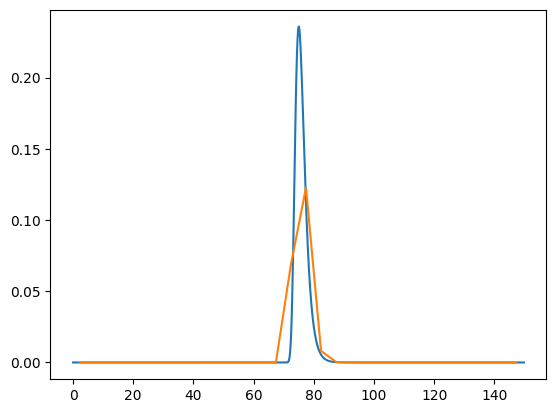

In [57]:
# 5 Ghz sampling assume 2 ns sigma
x = np.arange(0,150,0.2)
y = gumbel_pdf(x,75,2)

# means we have to reduce by a factor of 20 to reach P-One sampling rate
N=25
xd = downsample(x,N)
yd = downsample(y,N)

# boh looks about right
plt.plot(x,y)
plt.plot(xd,yd)

## Generate that matrix

In [58]:

A = np.zeros((len(xd),len(x)))
for i in range(len(x)):
    A[:,i] = downsample(gumbel_pdf(x,x[i],2),N) 


## 1 p.e. pulse

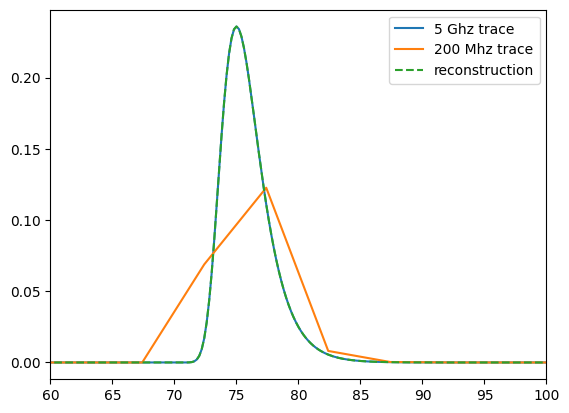

In [65]:
res = nnls(A,yd,1000)
zres = np.zeros(len(x))
for i in range(len(zres)):
    zres += res[i]*gumbel_pdf(x,x[i],2)

plt.plot(x,y,label='5 Ghz trace')
plt.plot(xd,yd,label='200 Mhz trace')
plt.plot(x,zres,label='reconstruction',ls='--')
plt.xlim(60,100)
plt.legend()

## 2 p.e. , 8 ns apart

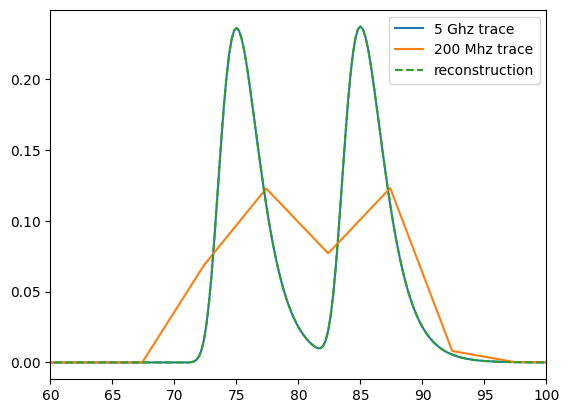

In [69]:
# lets try 2 pe
smpl_roll = 2
yd2 = yd+np.roll(yd,smpl_roll)

res2 = nnls(A,yd2,1000)
zres2 = np.zeros(len(x))
for i in range(len(zres2)):
    zres2 += res2[i]*gumbel_pdf(x,x[i],2)

plt.plot(x,y+np.roll(y,smpl_roll*N),label='5 Ghz trace')
plt.plot(xd,yd2,label='200 Mhz trace')
plt.plot(x,zres2,label='reconstruction',ls='--')
plt.xlim(60,100)
plt.legend()

## Adding baseline noise

# Apply to test data